Welcome to the Pyro implementation of my "flat" fantasy football model.  The "flat" refers to the fact that the model is not hierarchical.  I often refer to this model as the "pooled" model because I have not separated my model by teams here, and hence all players are pooled into a single "flat" model.  

Here are the dependencies of this project.  The dependencies are the same for both Jupyter Notebooks.  

In [1]:
%pip install pyro-ppl
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import matplotlib.pyplot as plt

import numpy as np
import pandas

In the next few cells we read the data and preprocess it.  Details on how I created data.csv can be found in the README.  

We pull in the raw data from my github repository.  Each row of the data corresponds to a single player in a given year.  

In [2]:
# data
data = pandas.read_csv("https://raw.githubusercontent.com/iandardik/CS7290_project/master/data.csv")
data = data.dropna()
data

,Player,ID,Team,Age,Position,Games,Games Started,Attempts,Yards,TD,1D,Lng,Y/A,Y/G,Fumbles,Year,Points,Yards Next Year,TD Next Year,Fumbles Next Year,Y/G Next Year,Games Next Year,Attempts Next Year,Points Next Year
0,Eddie George,GeorEd00,TEN,27,RB,16,16,403,1509,14,78,35,3.7,94.3,5,2000,224.9,939.0,5.0,8.0,58.7,16.0,315.0,107.9
1,Edgerrin James,JameEd00,IND,22,RB,16,16,387,1709,13,100,30,4.4,106.8,5,2000,238.9,662.0,3.0,3.0,110.3,6.0,151.0,78.2
2,Jerome Bettis,BettJe00,PIT,28,RB,16,16,355,1341,8,72,30,3.8,83.8,1,2000,180.1,1072.0,4.0,3.0,97.5,11.0,225.0,125.2
3,James Stewart,StewJa00,DET,29,RB,16,16,339,1184,10,66,34,3.5,74.0,4,2000,170.4,685.0,1.0,0.0,62.3,11.0,143.0,74.5
4,Stephen Davis,DaviSt00,WAS,26,RB,15,15,332,1318,11,72,50,4.0,87.9,4,2000,189.8,1432.0,5.0,6.0,89.5,16.0,356.0,161.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6356,Jarvis Landry,LandJa00,CLE,27,WR,16,16,1,10,0,1,10,10.0,0.6,0,2019,1.0,10.0,1.0,2.0,0.7,15.0,4.0,3.0
6361,Anthony Miller,MillAn02,CHI,25,WR,16,7,1,-1,0,0,-1,-1.0,-0.1,1,2019,-2.1,12.0,0.0,2.0,0.8,16.0,2.0,-2.8
6368,Allen Robinson,RobiAl02,CHI,26,WR,16,15,1,2,0,0,2,2.0,0.1,0,2019,0.2,-1.0,0.0,0.0,-0.1,16.0,1.0,-0.1
6374,Michael Thomas,ThomMi05,NOR,26,WR,16,15,1,-9,0,0,-9,-9.0,-0.6,1,2019,-2.9,1.0,0.0,0.0,0.1,7.0,1.0,0.1


Gather a list of all the teams in our data set

In [3]:

all_teams = np.unique(data["Team"].to_numpy())
num_teams = len(all_teams)
all_teams

array(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
       'DEN', 'DET', 'GNB', 'HOU', 'IND', 'JAX', 'KAN', 'LAC', 'LAR',
       'MIA', 'MIN', 'NOR', 'NWE', 'NYG', 'NYJ', 'OAK', 'PHI', 'PIT',
       'SDG', 'SEA', 'SFO', 'STL', 'TAM', 'TEN', 'WAS'], dtype=object)

Create a map of team name to index (index into the ```all_teams``` array).  This map is strictly for convenience.  


In [4]:
team_to_idx = {}
for i,team in enumerate(all_teams):
    team_to_idx[team] = i
data["Team Index"] = [team_to_idx[tm] for tm in data["Team"]]

In the following cell, we calculate the percent of attempts that each player had on his team on a given year.  We add this to the data set as a column named "Percent Attempts Of Team".  We also filter out any players who did not share *any* attempts with other players; this indicates flawed data (no NFL team gives *all* of its attempts to a single player) so we are not interested in modeling these players.  

In [5]:
att_key = "Attempts"
paot_key = "Percent Attempts Of Team"
percent_attempts_per_player = {}

for year in range(2000, 2020):
    percent_attempts_per_player[year] = {}
    year_data = data[data["Year"]==year]
    for team in all_teams:
        members = year_data[year_data["Team"]==team]
        ids = members["ID"].to_numpy()
        attempts = members[att_key].to_numpy()
        if len(attempts) > 0:
            total = sum(attempts)
            attempt_perc = np.array([a/total for a in attempts])
            for id, perc in zip(ids,attempt_perc):
                percent_attempts_per_player[year][id] = perc

papp_list = []
for i,row in data.iterrows():
    year = row["Year"]
    id = row["ID"]
    perc = percent_attempts_per_player[year][id]
    papp_list.append(perc)

data[paot_key] = papp_list
data = data[data[paot_key] < 1.0]

# sanity checks for percent attempts of team
for a in data[paot_key].to_numpy():
    assert(a > 0 and a < 1)

for year in range(2000, 2020):
    year_data = data[data["Year"]==year]
    for team in all_teams:
        atts = year_data[year_data["Team"]==team][paot_key]
        if len(atts) > 0:
            total = sum(atts)
            if not np.isclose(total, 1.0):
                print("total: {}".format(total))
                print("team: {}, year: {}".format(team, year))
            assert(np.isclose(total, 1.0))


The following cell is identical to the previous except that we create a column for percent attempts next year: "Percent Attempts Of Team Next Year".  We perform the same filtering.  

In [6]:

att_key = "Attempts Next Year"
paot_key = "Percent Attempts Of Team Next Year"
percent_attempts_per_player = {}

for year in range(2000, 2020):
    percent_attempts_per_player[year] = {}
    year_data = data[data["Year"]==year]
    for team in all_teams:
        members = year_data[year_data["Team"]==team]
        ids = members["ID"].to_numpy()
        attempts = members[att_key].to_numpy()
        if len(attempts) > 0:
            total = sum(attempts)
            attempt_perc = np.array([a/total for a in attempts])
            for id, perc in zip(ids,attempt_perc):
                percent_attempts_per_player[year][id] = perc

papp_list = []
for i,row in data.iterrows():
    year = row["Year"]
    id = row["ID"]
    perc = percent_attempts_per_player[year][id]
    papp_list.append(perc)

data[paot_key] = papp_list
data = data[data[paot_key] < 1.0]

# sanity checks for percent attempts of team
for a in data[paot_key].to_numpy():
    assert(a > 0 and a < 1)

for year in range(2000, 2020):
    year_data = data[data["Year"]==year]
    for team in all_teams:
        atts = year_data[year_data["Team"]==team][paot_key]
        if len(atts) > 0:
            total = sum(atts)
            if not np.isclose(total, 1.0):
                print("total: {}".format(total))
                print("team: {}, year: {}".format(team, year))
            assert(np.isclose(total, 1.0))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


```target_year``` is the year we want to predict for.  As such, we train on all data that is earlier than the year prior to the target, leaving the prior year as the hold out set for predicting the target year.  

In [7]:
target_year = 2020
holdout = data[data["Year"]==target_year-1]
data = data[data["Year"] < target_year-1]

Next, we gather several observations that we can use for training the model.  These observations will allow us to infer a distribution of values for the latent variables in our model.  

One important thing to note is that when we cap our data to ```num_obs``` observations.  This practice is not ideal, and at the very least I ought to be removing random points.  Truncating from one end of the array can bias our data, but I have done it here for convenience to leave more time for me to focus on my model.  

In [8]:
num_obs = 595

For each player in a given year, the percent of the attempts the player has on his team.

In [9]:
observed_percent_attempts = data["Percent Attempts Of Team"].to_numpy()
observed_percent_attempts = observed_percent_attempts[:num_obs]
len(observed_percent_attempts)

595

For each player in a given year, the percent of the attempts the player has on his team *next year*.

In [10]:
observed_percent_attempts_NY = data["Percent Attempts Of Team Next Year"].to_numpy()
observed_percent_attempts_NY = observed_percent_attempts_NY[:num_obs]
len(observed_percent_attempts_NY)

595

The number of attempts each team has.

In [11]:
observed_attempts = []

for year in range(2000, 2020):
    year_data = data[data["Year"]==year]
    for team in all_teams:
        attempts = year_data[year_data["Team"]==team]["Attempts"].to_numpy()
        if len(attempts) > 0:
            total = np.sum(attempts)
            observed_attempts.append(total)

observed_attempts = np.array(observed_attempts)
len(observed_attempts)

595

The number of attempts each team has *next year*.

In [12]:
observed_attempts_NY = []

for year in range(2000, 2020):
    year_data = data[data["Year"]==year]
    for team in all_teams:
        attempts = year_data[year_data["Team"]==team]["Attempts Next Year"].to_numpy()
        if len(attempts) > 0:
            total = np.sum(attempts)
            observed_attempts_NY.append(total)

observed_attempts_NY = np.array(observed_attempts_NY)
len(observed_attempts_NY)

595

For a given player on a given year, the number of points he will score *next year*.  

In [13]:
observed_points_NY = data["Points Next Year"].to_numpy()
observed_points_NY = observed_points_NY[:num_obs]
len(observed_points_NY)

595

This model has pooled all players to share a single alpha, beta, and mu hyperparameters.  The model is the same as the one I implemented in PyMC3 for the final presentation, except that I have used a LogNormal for hyperparameters that should be nonnegative.  This seems to have helped convergence.  

In [14]:
points_per_attempt = 0.8

def points_per_player():
    alpha = pyro.sample("alpha", dist.LogNormal(loc=np.log(5), scale=0.1))
    beta = pyro.sample("beta", dist.LogNormal(loc=np.log(20), scale=0.03))
    percent_attempts = pyro.sample("percent_attempts", dist.Beta(alpha, beta))
    percent_attempts_NY = pyro.sample("percent_attempts_NY", dist.Beta(percent_attempts, 1-percent_attempts))

    mu = pyro.sample("mu", dist.Normal(350, 3))
    sigma = pyro.sample("sigma", dist.LogNormal(loc=np.log(80), scale=0.04))
    team_attempts = pyro.sample("team_attempts", dist.Normal(mu, sigma))
    team_attempts_NY = pyro.sample("team_attempts_NY", dist.Normal(team_attempts, 2))
    
    attempts_NY = pyro.sample("attempts_NY", dist.Normal(loc=(percent_attempts_NY * team_attempts_NY), scale=2))
    mu_points_NY = attempts_NY * points_per_attempt
    return pyro.sample("points_NY", dist.Normal(loc=mu_points_NY, scale=2))



The prior distribution seems to concentrate to closely to the -5 to 25 point range, when in fact it ought to be wider and spread out closer to 300 attempts.  I have noticed that when the prior spreads out as far as we expect then the posterior distribution is far too wide.  This is likely an issue with my paramaterization, however I will continue with this model since it has yielded the best results.  Furthermore, the prior is fairly reasonable.  We expect most player to score between -5 to 25 points a year; far fewer score in the 25 to 300 range.  

Sample: 100%|██████████| 300/300 [05:46,  1.15s/it, step size=3.99e-02, acc. prob=0.937]



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
                alpha      5.04      0.46      5.03      4.24      5.73    260.88      1.00
          attempts_NY     10.22     20.73      2.21     -4.54     30.82     13.90      0.99
                 beta     19.99      0.61     19.94     19.13     21.05    191.31      1.00
                   mu    349.71      2.82    349.70    345.70    354.13    193.81      1.00
     percent_attempts      0.19      0.06      0.18      0.08      0.29    230.01      1.00
  percent_attempts_NY      0.03      0.05      0.00      0.00      0.11     16.35      1.00
            points_NY      7.99     16.93      1.58     -5.37     25.99     13.89      1.00
                sigma     80.19      3.18     80.08     74.52     84.38    455.42      1.00
        team_attempts    347.56     98.10    360.91    261.42    470.35      4.56      1.20
     team_attempts_NY    347.32     98.03    360.61    254.44    461.25      4.

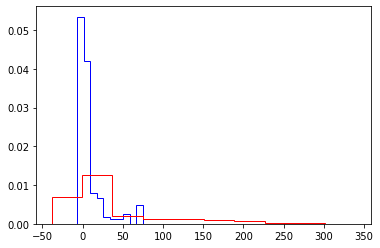

In [15]:
# prior distribution check
nuts_kernel = NUTS(points_per_player)
mcmc = MCMC(nuts_kernel, warmup_steps=100, num_samples=200)
mcmc.run()
mcmc.summary()
pts_ny = mcmc.get_samples()["points_NY"].numpy()
plt.hist(pts_ny, density=True, histtype="step", color="blue")
plt.hist(observed_points_NY, density=True, histtype="step", color="red")
plt.show()

Next, we sample from the posterior model.

In [16]:
observed_data = {
    "percent_attempts": torch.tensor(observed_percent_attempts),
    "percent_attempts_NY": torch.tensor(observed_percent_attempts_NY),
    "team_attempts": torch.tensor(observed_attempts),
    "team_attempts_NY": torch.tensor(observed_attempts_NY),
    "points_NY": torch.tensor(observed_points_NY)
}

posterior_model = pyro.condition(points_per_player, data=observed_data)

nuts_kernel = NUTS(posterior_model)
mcmc = MCMC(nuts_kernel, warmup_steps=100, num_samples=400)
mcmc.run()
mcmc.summary()
samples = mcmc.get_samples()


Sample: 100%|██████████| 500/500 [14:38,  1.76s/it, step size=2.53e-02, acc. prob=0.724]



                      mean       std    median      5.0%     95.0%     n_eff     r_hat
           alpha      1.22      0.04      1.22      1.15      1.28    392.27      1.00
  attempts_NY[0]    189.81      1.46    189.74    187.87    192.52    302.91      1.00
  attempts_NY[1]     99.24      1.76     99.19     96.53    101.87    389.33      1.00
  attempts_NY[2]     85.73      1.60     85.77     83.02     88.44    371.74      1.00
  attempts_NY[3]    120.93      1.44    121.02    118.54    123.43    405.29      1.00
  attempts_NY[4]    107.29      1.43    107.32    105.08    109.77    435.70      1.00
  attempts_NY[5]    177.67      1.45    177.72    175.42    179.82    621.77      1.00
  attempts_NY[6]    295.91      1.56    295.87    293.24    298.23    460.62      1.00
  attempts_NY[7]    111.09      1.40    111.05    108.88    113.26    340.32      1.00
  attempts_NY[8]    167.13      1.57    167.23    164.55    169.62    390.03      1.01
  attempts_NY[9]    195.21      1.61    19

Next we perform posterior distribution checks

For each sample (infered values of our latent variables), generate 100 samples for "points next year" and plot the distribution.  This helps us visualize the posterior distribution.  

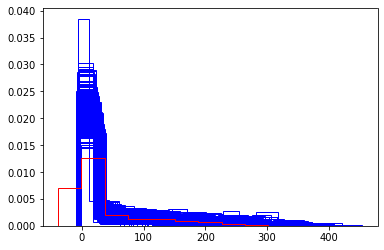

In [17]:
params = [
    samples["alpha"].numpy(),
    samples["beta"].numpy(),
    samples["mu"].numpy(),
    samples["sigma"].numpy(),
]

for alpha, beta, mu, sigma in zip(*params):
    sim_data = {
        "alpha": torch.tensor(alpha),
        "beta": torch.tensor(beta),
        "mu": torch.tensor(mu),
        "sigma": torch.tensor(sigma)
    }
    post_check_model = pyro.condition(points_per_player, data=sim_data)
    sims = []
    for _ in range(100):
        points_NY = pyro.sample("pny", post_check_model)
        sims.append(points_NY)
    plt.hist(sims, density=True, histtype="step", color="blue")

plt.hist(observed_points_NY, density=True, histtype="step", color="red")
plt.show()

Finally, we use the posterior distribution to create a player ranking.

In [18]:
N = 100
holdout_year = holdout.head(N)
rank = {}
rev_rank = {}

print("".join(["." for _ in range(N)]))

for i,row in holdout_year.iterrows():
    id = row["ID"]
    player = row["Player"]
    percent_att = row["Percent Attempts Of Team"]
    sims = []
    for alpha, beta, mu, sigma in zip(*params):
        sim_data = {
            "alpha": torch.tensor(alpha),
            "beta": torch.tensor(beta),
            "mu": torch.tensor(mu),
            "sigma": torch.tensor(sigma),
            "percent_attempts": torch.tensor(percent_att)
        }
        pm = pyro.condition(points_per_player, data=sim_data)
        sim = pyro.sample("pm", pm)
        sims.append(sim)
    key = np.mean(sims)
    rank[key] = {"ID": id, "Player": player}
    rev_rank[id] = {"Rank": key, "Player": player}
    print(".", end="")
print()

....................................................................................................
....................................................................................................


In [19]:
true_rank = {}
rev_true_rank = {}
for i,row in holdout_year.iterrows():
    id = row["ID"]
    player = row["Player"]
    key = row["Points Next Year"]
    true_rank[key] = {"ID": id, "Player": player}
    rev_true_rank[id] = {"Rank": key, "Player": player}

I was not able to figure out how to calculate the WAIC in time to hand in this project.  Instead I calculated MSE to compare models.  This model consistently has a sqrt(MSE) (with 2020 as the holdout set) in the high 60's.  I chose to look at sqrt(MSE) instead of MSE because it is more intuitive to me (the same way standard deviation is often more intuitive than variance).  

Perhpas unsurprisingly, absolute prediction error is [very loosely] correlated with the magnitude of our prediction.  This is made clear in the chat below.  

mse: 4833.461259404108
mse**0.5: 69.52309874713661


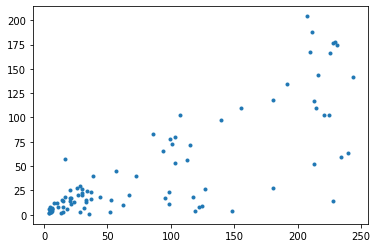

In [20]:
pred = []
diffs = []
for key in reversed(sorted(true_rank.keys())):
    id = true_rank[key]["ID"]
    player = true_rank[key]["Player"]
    predicted = rev_rank[id]["Rank"]
    actual = rev_true_rank[id]["Rank"]
    diff = abs(predicted - actual)
    pred.append(predicted)
    diffs.append(diff)

mse = np.mean([d**2 for d in diffs])
print("mse: {}".format(mse))
print("mse**0.5: {}".format(mse**0.5))

plt.plot(pred, diffs, ".")
plt.show()

Here is the predicted ranking list that one can use to choose players to draft for their fantasy football team.  Here is pseudo code for the algorithm:

```
P -> probability distribution for the # of points each player will score next year
E -> expectation
player_predictions = [E(P(points next year|team,team att %)) for player in all_players]
display(player_predictions.sort())
```

In [21]:

print("Projected Rank:")
for k in reversed(sorted(rank.keys())):
    print("{}: {}".format(rank[k]["Player"], k))


Projected Rank:
Adrian Peterson: 243.65062976846946
Nick Chubb: 240.0586558994288
Josh Jacobs: 234.15254297212923
Phillip Lindsay: 230.80796477168397
Christian McCaffrey: 229.77919478654152
Sony Michel: 227.85389049506293
Dalvin Cook: 227.57305708728256
Joe Mixon: 225.58768796642016
Ezekiel Elliott: 224.7800962233452
Todd Gurley: 220.49340144574577
Leonard Fournette: 216.39325799692728
James Conner: 214.37247990667774
Chris Carson: 212.996814107631
Aaron Jones: 212.97091175375905
Marlon Mack: 212.39380531861545
Devonta Freeman: 211.32631313267402
Le'Veon Bell: 210.02857138721157
Saquon Barkley: 207.45289511450952
Carlos Hyde: 191.90450458217074
Derrick Henry: 180.77069337636624
David Montgomery: 180.28887852966548
LeSean McCoy: 170.42989892214553
Kalen Ballage: 155.5786940971441
Melvin Gordon: 148.4140743695928
Mark Ingram: 139.4674717582967
David Johnson: 127.23090850762951
Miles Sanders: 124.21300539681792
Kyler Murray: 121.87547260065152
Lamar Jackson: 118.99612871695868
Ronald Jone